# Yelp Reviews Sentiment Analysis

## Step: Loading packages and connecting to Spark cluster

In [1]:
# Run this cell below only once:
import findspark
findspark.init()

# import the library
import pyspark
from pyspark.sql import SparkSession
# for Spark 2.0, we have a unified entry point to the cluster
spark = SparkSession.builder.\
    getOrCreate()
#spark = SparkSession.builder.master('local[2]').getOrCreate()
# for previous versions, we can simulate SparkContext and SQLContext
sc = spark.sparkContext
sqlContext = spark

# Display information about current execution
#spark.conf.get('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES')

In [2]:
import pandas as pd

In [3]:
from functools import reduce

In [117]:
from pyspark.sql import SparkSession, DataFrame, DataFrameNaFunctions
from pyspark.sql import functions as fn
import numpy as np

In [5]:
spark = SparkSession.builder.getOrCreate()\

In [6]:
from pyspark.sql import SQLContext
print (sc)

## Step: Convert the dataset into Spark dataframe and perform data cleaning operations

In [38]:
df_all = spark.read\
    .format('com.databricks.spark.csv')\
    .option('header','true')\
    .option('charset', 'UTF-8')\
    .csv('df_all.csv')

In [39]:
df_all.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- name: string (nullable = true)
 |-- business_rating: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- compliment_list: string (nullable = true)
 |-- compliment_hot: string (nullable = true)
 |-- compliment_cute: string (nullable = true)
 |-- compliment_note: string (nullable = true)
 |-- compliment_photos: string (nullable = true)
 |-- compliment_more: string (nullable = true)
 |-- compliment_writer: string (nullable = true)
 |-- compliment_plain: string (nullable = true)
 |-- user_avg_rating: string (nullable = true)
 |-- co

In [40]:
df_all = df_all.na.drop(subset=["text"]) # Remove rows with NULL in column 'content

In [41]:
df_all=df_all.withColumn("review_rating_f", fn.col("review_rating_f").cast("int"))
# Change the datatype of review_rating to integer

d1=df_all.where(fn.col('review_rating_f')==1)
d0=df_all.where(fn.col('review_rating_f')==0)
df_all= d1.unionAll(d0)
df_all.groupby('review_rating_f').agg(fn.count('*')).show()
#Clen the dataframe as per required output

+---------------+--------+
|review_rating_f|count(1)|
+---------------+--------+
|              1|  511419|
|              0|  666259|
+---------------+--------+



In [42]:
df_all = df_all.select('_c0','name','review_count','business_id','user_id','review_id',\
              'text','business_rating','review_rating_f','review_rating','cool','funny','useful',\
              ((fn.col('compliment_profile')+fn.col('compliment_cool')+fn.col('compliment_funny')+fn.col('compliment_plain')+\
               fn.col('compliment_writer')+fn.col('compliment_more')+fn.col('compliment_photos')+fn.col('compliment_note')+\
               fn.col('compliment_cute')+fn.col('compliment_list')+fn.col('compliment_hot'))/11).alias('compliment_average'))

In [43]:
df_all.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- business_rating: string (nullable = true)
 |-- review_rating_f: integer (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- compliment_average: double (nullable = true)



In [35]:
df_all.show(100)

+----+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+--------------------+--------------------+------------------+--------------------+-------------------+
| _c0|                name|    review_count|         business_id|             user_id|           review_id|                text|business_rating|review_rating_f|       review_rating|                cool|             funny|              useful| compliment_average|
+----+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+--------------------+--------------------+------------------+--------------------+-------------------+
|   9|Sting Alarm Las V...|              14|XqDeiaPSG0-fBbOXD...|efaUGV60LFI4v6bWP...|xqFpx6FkEpjow6JAh...|John the director...|            3.5|              1|                 5.0|                   1|         

In [122]:
df_all.count()

1177678

## Step: Tokenize the reviews text

In [15]:
from pyspark.ml.feature import Tokenizer

In [16]:
df_token=tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

In [17]:
df_token = df_all.na.drop(subset=["text"]) # Remove rows with NULL in column 'content'
df_token=tokenizer.transform(df_token)

In [18]:
df_token.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- business_rating: string (nullable = true)
 |-- review_rating_f: integer (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- compliment_average: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Step: Vectorize the review tokens/words

In [19]:
from pyspark.ml.feature import CountVectorizer

In [20]:
count_vectorizer_estimator = CountVectorizer(inputCol='words', outputCol='features')

In [21]:
count_vectorizer_transformer = count_vectorizer_estimator.fit(df_token)

In [22]:
count_vectorizer_transformer.transform(df_token).show()

+---+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+-------------+----+------------------+-----------------+-------------------+--------------------+--------------------+
|_c0|                name|    review_count|         business_id|             user_id|           review_id|                text|business_rating|review_rating_f|review_rating|cool|             funny|           useful| compliment_average|               words|            features|
+---+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+-------------+----+------------------+-----------------+-------------------+--------------------+--------------------+
|  9|Sting Alarm Las V...|              14|XqDeiaPSG0-fBbOXD...|efaUGV60LFI4v6bWP...|xqFpx6FkEpjow6JAh...|John the director...|            3.5|              1|       

In [23]:
count_vectorizer_transformer.vocabulary

['the',
 'and',
 '',
 'to',
 'i',
 'a',
 'was',
 'of',
 'in',
 'for',
 'my',
 'is',
 'they',
 'it',
 'that',
 'with',
 'you',
 'this',
 'we',
 'on',
 'have',
 'at',
 'but',
 'not',
 'had',
 'are',
 'me',
 'so',
 'were',
 'very',
 'be',
 'he',
 'as',
 'all',
 'if',
 'from',
 'our',
 'would',
 'there',
 'get',
 'an',
 'when',
 'out',
 'great',
 'up',
 'just',
 'about',
 'one',
 'time',
 'will',
 'their',
 'or',
 'no',
 'like',
 'your',
 'been',
 'what',
 'them',
 'she',
 'do',
 'service',
 'here',
 'place',
 'only',
 "it's",
 'back',
 'even',
 'good',
 "'wheelchairaccessible:",
 'car',
 'after',
 'go',
 'by',
 'can',
 'did',
 'really',
 'room',
 'because',
 'has',
 'other',
 'got',
 'some',
 'which',
 'true\']"',
 'us',
 'more',
 'his',
 'also',
 "don't",
 'never',
 'staff',
 'could',
 'her',
 'than',
 "didn't",
 'recommend',
 'always',
 '-',
 'went',
 'who',
 'over',
 'first',
 'nice',
 'new',
 'work',
 'any',
 'hotel',
 'told',
 "i'm",
 'going',
 'called',
 'how',
 'then',
 'see',
 'pe

In [24]:
from pyspark.ml import Pipeline

In [25]:
pipeline_cv_estimator = Pipeline(stages=[tokenizer, count_vectorizer_estimator])

In [26]:
pipeline_cv_transformer = pipeline_cv_estimator.fit(df_all)

In [27]:
pipeline_cv_transformer.transform(df_all).show()

+---+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+-------------+----+------------------+-----------------+-------------------+--------------------+--------------------+
|_c0|                name|    review_count|         business_id|             user_id|           review_id|                text|business_rating|review_rating_f|review_rating|cool|             funny|           useful| compliment_average|               words|            features|
+---+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+-------------+----+------------------+-----------------+-------------------+--------------------+--------------------+
|  9|Sting Alarm Las V...|              14|XqDeiaPSG0-fBbOXD...|efaUGV60LFI4v6bWP...|xqFpx6FkEpjow6JAh...|John the director...|            3.5|              1|       

In [44]:
sentiments_df = spark.read.parquet('/datasets/sentiment_analysis/sentiments.parquet')

In [45]:
sentiments_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: long (nullable = true)



In [46]:
sentiments_df.where(fn.col('sentiment') == 1).show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



In [47]:
sentiments_df.where(fn.col('sentiment') == -1).show(5)

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



In [48]:
sentiments_df.where(fn.col('sentiment') == -1).show(5)

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



In [49]:
from pyspark.ml.feature import RegexTokenizer

In [50]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

In [51]:
content_words_df = tokenizer.transform(df_all)

In [52]:
content_words_df.select('business_id', fn.explode('words').alias('word')).show(5)

+--------------------+----------+
|         business_id|      word|
+--------------------+----------+
|XqDeiaPSG0-fBbOXD...|      john|
|XqDeiaPSG0-fBbOXD...|       the|
|XqDeiaPSG0-fBbOXD...|  director|
|XqDeiaPSG0-fBbOXD...|        of|
|XqDeiaPSG0-fBbOXD...|operations|
+--------------------+----------+
only showing top 5 rows



In [53]:
content_word_sentiment_df = content_words_df.\
    select('business_id', fn.explode('words').alias('word')).\
    join(sentiments_df, 'word')

In [54]:
simple_sentiment_prediction_df = content_word_sentiment_df.\
    groupBy('business_id').\
    agg(fn.avg('sentiment').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))

In [55]:
simple_sentiment_prediction_df.show(15)

+--------------------+-------------------+---------+
|         business_id|      avg_sentiment|predicted|
+--------------------+-------------------+---------+
|zSFutuGG7NcL60-N9...|0.04963041182682154|      1.0|
|j0_CApMCHDJBYJg1X...| 0.6011816838995568|      1.0|
|o8uCIT_YDDDr9KExf...|                1.0|      1.0|
|5HeI2iev-JWFI-S8C...| 0.7185185185185186|      1.0|
|35X1ZV9tSEqB__yJE...|0.25396825396825395|      1.0|
|aZbbt_RPKV8vUY7GW...|0.01818181818181818|      1.0|
|eUa2VP06FTmyWdYzY...| 0.7373737373737373|      1.0|
|wwiLGg0Un113ezT75...| 0.6451612903225806|      1.0|
|f4mh1Y0rnvbJRfQ3j...|0.44680851063829785|      1.0|
|tzRpAi91Rs0-S0Ico...|                1.0|      1.0|
|gOCizq2d2ku1LKKX-...| 0.2765957446808511|      1.0|
|2ZzThh_QS7JnNApvN...| 0.5384615384615384|      1.0|
|TptdGz1YIQby7uvvA...| 0.5076923076923077|      1.0|
|5LZhDRyz3q_UNZ29c...| 0.7722095671981777|      1.0|
|b-dMCUh7T2Kya1O7Z...| 0.3230769230769231|      1.0|
+--------------------+-------------------+----

In [56]:
df_all.\
    join(simple_sentiment_prediction_df, 'business_id').\
    select(fn.expr('float(review_rating_f = predicted)').alias('correct')).\
    select(fn.avg('correct')).\
    show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.703306924803288|
+-----------------+



## Step: Data-Driven Approach

In [57]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
len(stop_words)

319

In [58]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

In [59]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [60]:
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(df_all)

In [61]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [62]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(df_all)

In [63]:
tfidf_df = idf_pipeline.transform(df_all)

In [64]:
tfidf_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- business_rating: string (nullable = true)
 |-- review_rating_f: integer (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- compliment_average: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)



In [65]:
training_df, validation_df, testing_df = df_all.randomSplit([0.6, 0.3, 0.1], seed=0)

In [66]:
[training_df.count(), validation_df.count(), testing_df.count()]

[706309, 353324, 118045]

In [67]:
#  Logistic Regression
from pyspark.ml.classification import LogisticRegression

In [68]:
df_all.groupby('review_rating_f').agg(fn.count('*')).show()

+---------------+--------+
|review_rating_f|count(1)|
+---------------+--------+
|              1|  511419|
|              0|  666259|
+---------------+--------+



In [69]:
lr = LogisticRegression().\
    setLabelCol('review_rating_f').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

In [70]:
lr_pipeline = Pipeline(stages=[idf_pipeline, lr]).fit(training_df)

In [71]:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = review_rating_f)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.8615435124701407|
+------------------+



In [72]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

In [73]:
coeffs_df.sort_values('weight').head(5)

,weight,word
54396,-5.171028,hedging
57984,-5.123092,triceratops
59925,-4.298238,presumption
45026,-4.213830,enwiller
54028,-3.991321,terminer


In [74]:
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('review_rating_f').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [75]:
en_lr_estimator = Pipeline(
    stages=[tokenizer, sw_filter, cv, idf, en_lr])

In [76]:
en_lr_pipeline = en_lr_estimator.fit(training_df)

In [77]:
en_lr_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = review_rating_f)'))).show()

+------------------------------------------+
|avg(float((prediction = review_rating_f)))|
+------------------------------------------+
|                        0.8513913575075568|
+------------------------------------------+



In [78]:
en_weights = en_lr_pipeline.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': en_lr_pipeline.stages[2].vocabulary, 'weight': en_weights})

In [79]:
en_coeffs_df.sort_values('weight').head(60)

,weight,word
67,-0.348973,restaurantspricerange
6,-0.280234,true
229,-0.256048,worst
14,-0.245198,wheelchairaccessible
230,-0.214439,rude
276,-0.184853,horrible
397,-0.151311,terrible
847,-0.145940,unprofessional
498,-0.134817,poor
94,-0.132525,false


In [80]:
en_coeffs_df.sort_values('weight', ascending=False).head(50)

,weight,word
2,0.455462,great
61,0.309306,amazing
76,0.302821,highly
23,0.281265,recommend
31,0.277850,best
77,0.274903,professional
120,0.268551,thank
95,0.268484,awesome
151,0.261727,excellent
27,0.256317,friendly


In [81]:
en_coeffs_df.query('weight == 0.0').shape

(47665, 2)

In [82]:
en_coeffs_df.query('weight == 0.0').shape[0]/en_coeffs_df.shape[0]

0.9940355779858606

In [83]:
en_coeffs_df.query('weight == 0.0').head(15)

,weight,word
1,0.0,s
7,0.0,place
8,0.0,like
10,0.0,car
12,0.0,did
19,0.0,got
21,0.0,day
24,0.0,didn
28,0.0,went
29,0.0,m


In [84]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [85]:
en_lr_estimator.getStages()

[RegexTokenizer_42fdb348b4e82308477d,
 StopWordsRemover_4d1f8fa26085b3e88eec,
 CountVectorizer_46489a9b70dee41d1a37,
 IDF_434fb949b0e40f8933f8,
 LogisticRegression_44a6bddbfa35cbc604a2]

In [86]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

In [87]:
grid

[{Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. F

In [88]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [89]:
# estimate the accuracy of each of them:
accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(review_rating_f = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

In [90]:
accuracies

[0.8671955485616601,
 0.8671955485616601,
 0.8671955485616601,
 0.8749617914435476,
 0.8689757842659995,
 0.8589679727389026,
 0.8757825678414147,
 0.8587528727173925,
 0.8452581766310808]

In [91]:
import numpy as np

In [92]:
best_model_idx = np.argmax(accuracies)

In [93]:
grid[best_model_idx]

{Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='regParam', doc='regularization parameter (>= 0).'): 0.02,
 Param(parent='LogisticRegression_44a6bddbfa35cbc604a2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

In [94]:
best_model = all_models[best_model_idx]

In [95]:
accuracies[best_model_idx]

0.8757825678414147

In [96]:
bestModelDF = best_model.transform(df_all)

In [97]:
bestModelDF.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- business_rating: string (nullable = true)
 |-- review_rating_f: integer (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- compliment_average: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [98]:
bestModelDF.select('business_id', 'text', 'prediction').show(30)

+--------------------+--------------------+----------+
|         business_id|                text|prediction|
+--------------------+--------------------+----------+
|XqDeiaPSG0-fBbOXD...|John the director...|       1.0|
|zC7ldegnDoXg-Wln5...|Nar and all the p...|       1.0|
|O7RMINvCcGVNTMlD7...|Thanks to Soubi w...|       1.0|
|oYwLxROH5RihyFxrd...|My Wife and I hav...|       1.0|
|MCX_cBs_LUqzuUzd-...|This was my first...|       1.0|
|zOqJqDlWT0CF986D0...|I used to visit t...|       1.0|
|po-05-AGCVxEme-Sb...|Jeff is a top-not...|       1.0|
|Lh03t7LM7R8uKpgyv...|Dr. Lee is a wond...|       1.0|
|0DI8Dt2PJp07XkVvI...| 'WheelchairAcces...|       0.0|
|DlS2X40L4KywtwO4Y...|        'WiFi: no']"|       0.0|
|Sbv16xQcM_DFLv3eh...|Rewind 7 years ag...|       1.0|
|wMsy-LOjrpSg-tbnl...|Recently returned...|       1.0|
|LTlCaCGZE14GuaUXU...|There aren't enou...|       1.0|
|IVKVk7ZAPdQi6S40U...|I just washed my ...|       1.0|
|HZrvNH7VTHUDcYqwF...|Ive brought my do...|       1.0|
|LTlCaCGZE

In [100]:
bestModelDF.groupBy('name').\
    agg(fn.count('name').alias('Review_count')).\
    where(fn.col('Review_count')>500).\
    orderBy(fn.desc('Review_count')).show(20,False)

+------------------------------------------+------------+
|name                                      |Review_count|
+------------------------------------------+------------+
| 'validated': False                       |475601      |
| 'lunch': False                           |9127        |
| 'lot': False                             |4608        |
| 'classy': False                          |3373        |
|The Cosmopolitan of Las Vegas             |2854        |
|ARIA Resort & Casino                      |2784        |
|Luxor Hotel and Casino Las Vegas          |2638        |
|McCarran International Airport            |2577        |
| 'validated': True                        |2534        |
|MGM Grand Hotel                           |2514        |
|The Venetian Las Vegas                    |2427        |
|Enterprise Rent-A-Car                     |2179        |
|Bellagio Hotel                            |2081        |
|Flamingo Las Vegas Hotel & Casino         |2047        |
|Planet Hollyw

In [101]:
%matplotlib inline

In [102]:
import seaborn

In [103]:
sentiment_pd = best_model.\
    transform(df_all).\
    groupby('name').\
    agg(fn.avg('prediction').alias('prediction'), 
        (2*fn.stddev('prediction')/fn.sqrt(fn.count('*'))).alias('err')).\
    toPandas()

In [104]:
arr = ["The Cosmopolitan of Las Vegas", "ARIA Resort & Casino", "Luxor Hotel and Casino Las Vegas", "McCarran International Airport", "MGM Grand Hotel", "The Venetian Las Vegas", "Enterprise Rent-A-Car", "Bellagio Hotel", "Flamingo Las Vegas Hotel & Casino", "Planet Hollywood Las Vegas Resort & Casino", "Mandalay Bay Resort & Casino", "Excalibur Hotel", "Wynn Las Vegas", "Caesars Palace Las Vegas Hotel & Casino", "Phoenix Sky Harbor International Airport"]


In [105]:
bestModelPD500 = sentiment_pd.loc[sentiment_pd['name'].isin(arr)]

In [106]:
bestModelPD500

,name,prediction,err
1702,Excalibur Hotel,0.308743,0.021604
9243,Mandalay Bay Resort & Casino,0.549766,0.022720
11890,Phoenix Sky Harbor International Airport,0.426941,0.023641
18490,McCarran International Airport,0.390376,0.019223
18496,Flamingo Las Vegas Hotel & Casino,0.316072,0.020558
20397,Caesars Palace Las Vegas Hotel & Casino,0.515713,0.023684
20883,The Venetian Las Vegas,0.727235,0.018085
25845,Enterprise Rent-A-Car,0.643873,0.020521
32383,Bellagio Hotel,0.653532,0.020867
35598,Luxor Hotel and Casino Las Vegas,0.301744,0.017877


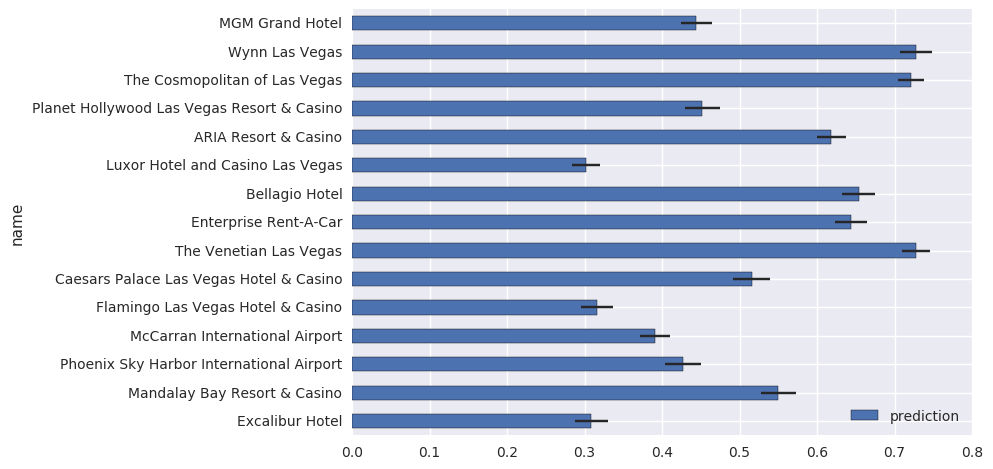

In [107]:
bestModelPD500.plot(x='name', y='prediction', xerr='err', kind='barh');

In [123]:
# Bar Plot showing a list of businesses with most number of reviews